Loading dataset...

Dataset Information:
Shape of the dataset: (9551, 21)

First 5 rows of the dataset:
   Restaurant ID         Restaurant Name  Country Code              City  \
0        6317637        Le Petit Souffle           162       Makati City   
1        6304287        Izakaya Kikufuji           162       Makati City   
2        6300002  Heat - Edsa Shangri-La           162  Mandaluyong City   
3        6318506                    Ooma           162  Mandaluyong City   
4        6314302             Sambo Kojin           162  Mandaluyong City   

                                             Address  \
0  Third Floor, Century City Mall, Kalayaan Avenu...   
1  Little Tokyo, 2277 Chino Roces Avenue, Legaspi...   
2  Edsa Shangri-La, 1 Garden Way, Ortigas, Mandal...   
3  Third Floor, Mega Fashion Hall, SM Megamall, O...   
4  Third Floor, Mega Atrium, SM Megamall, Ortigas...   

                                     Locality  \
0   Century City Mall, Poblacion, Makati City   
1  L

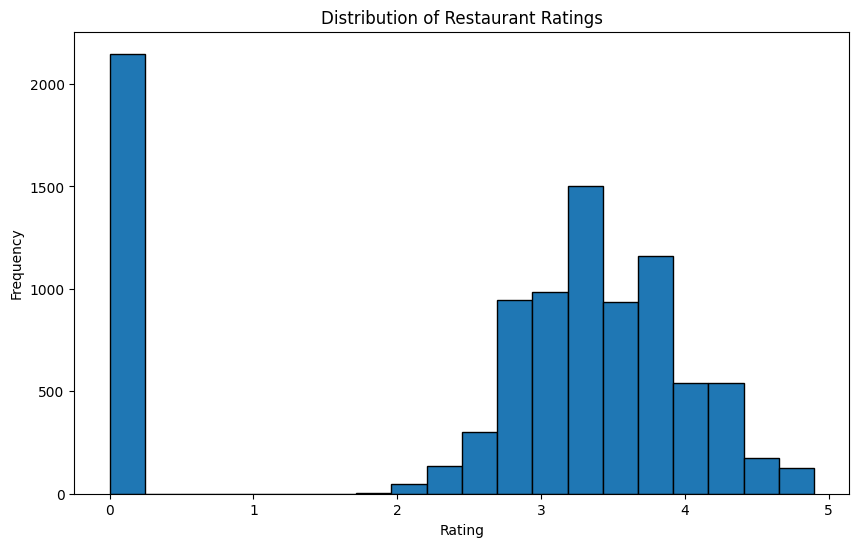

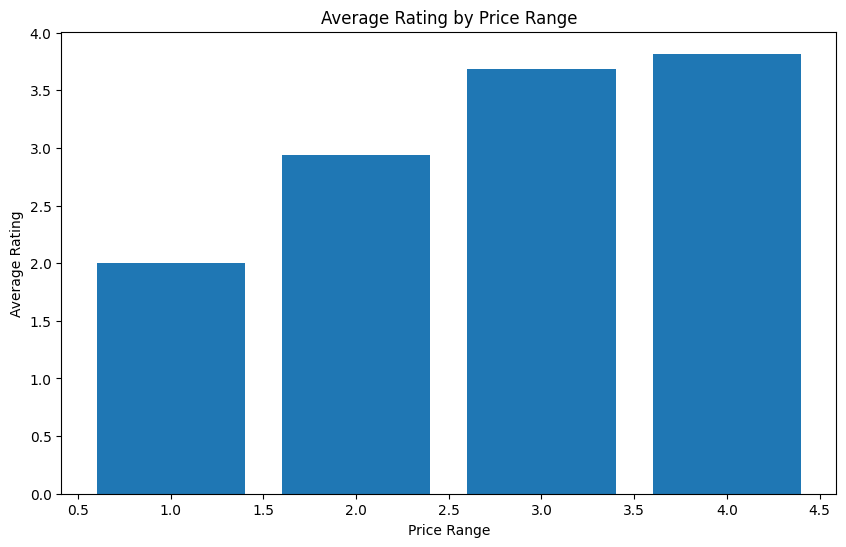

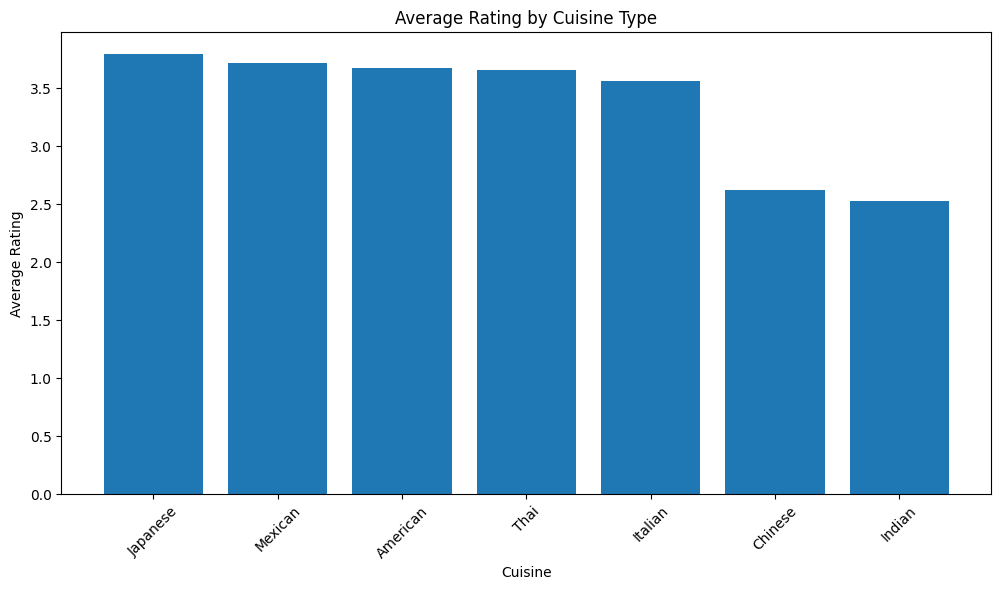

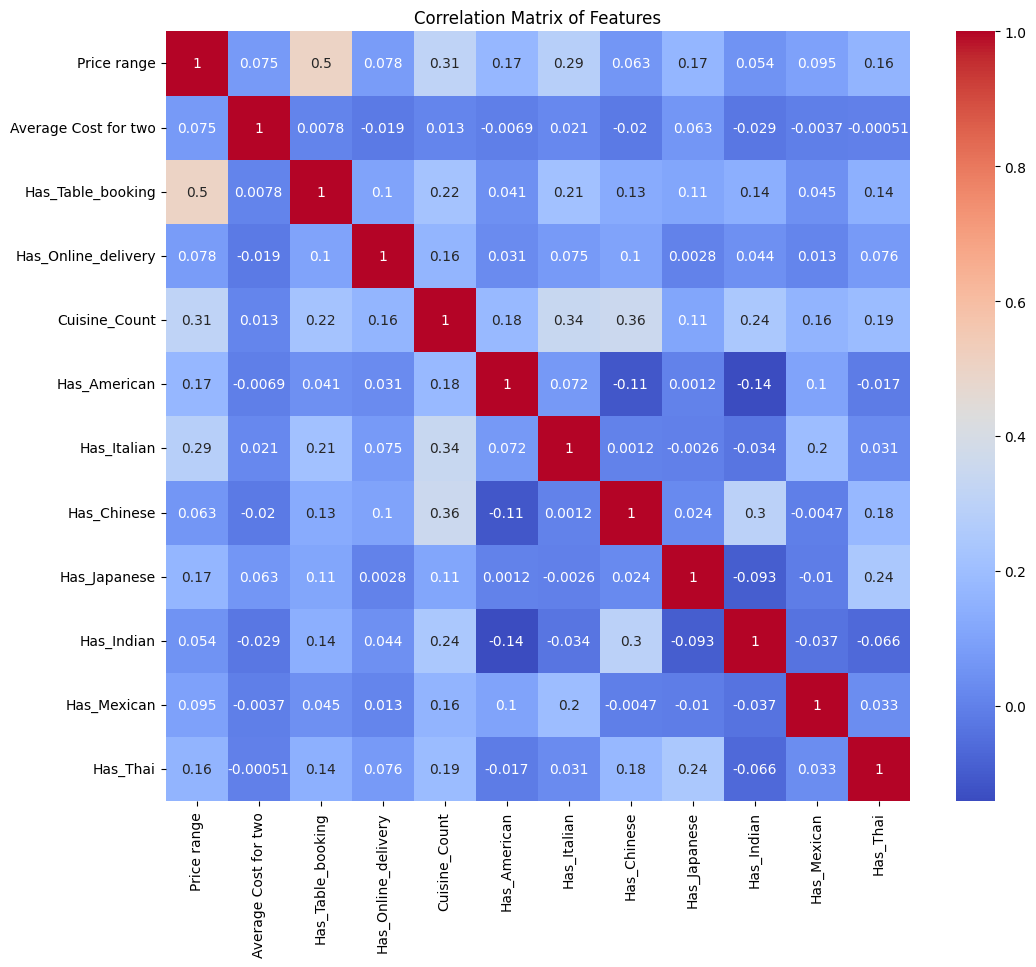

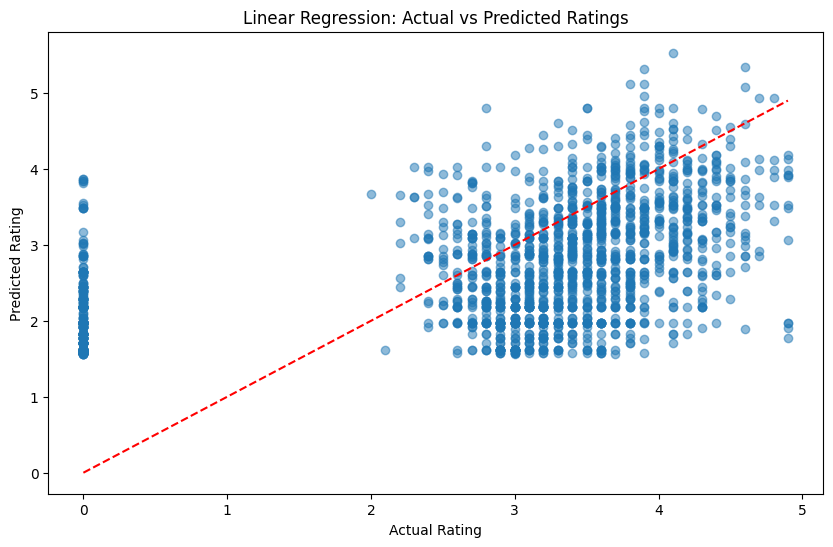

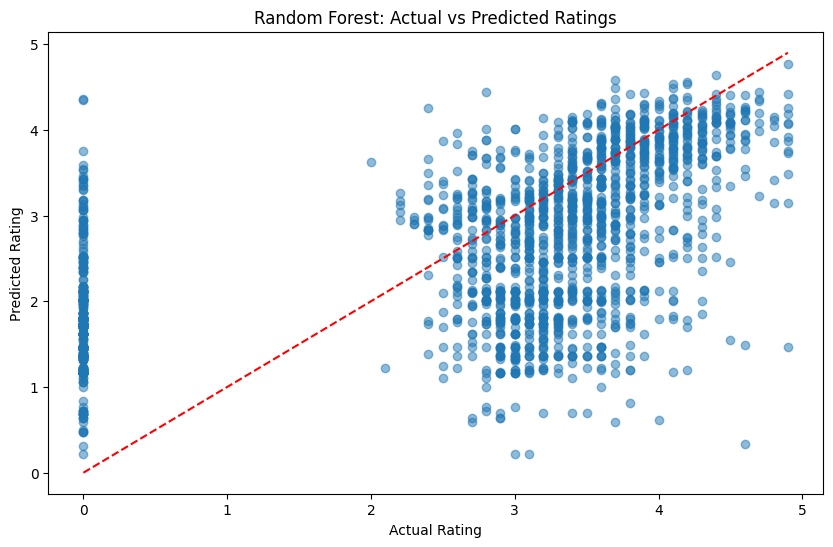

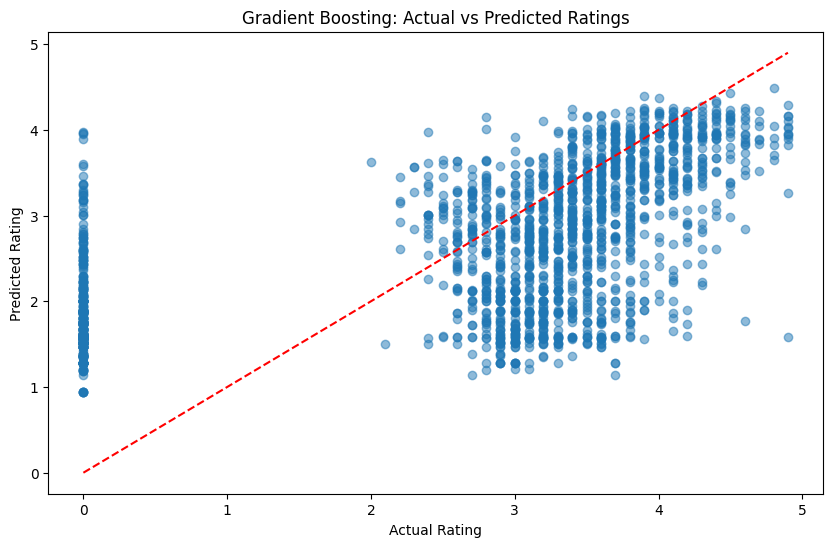

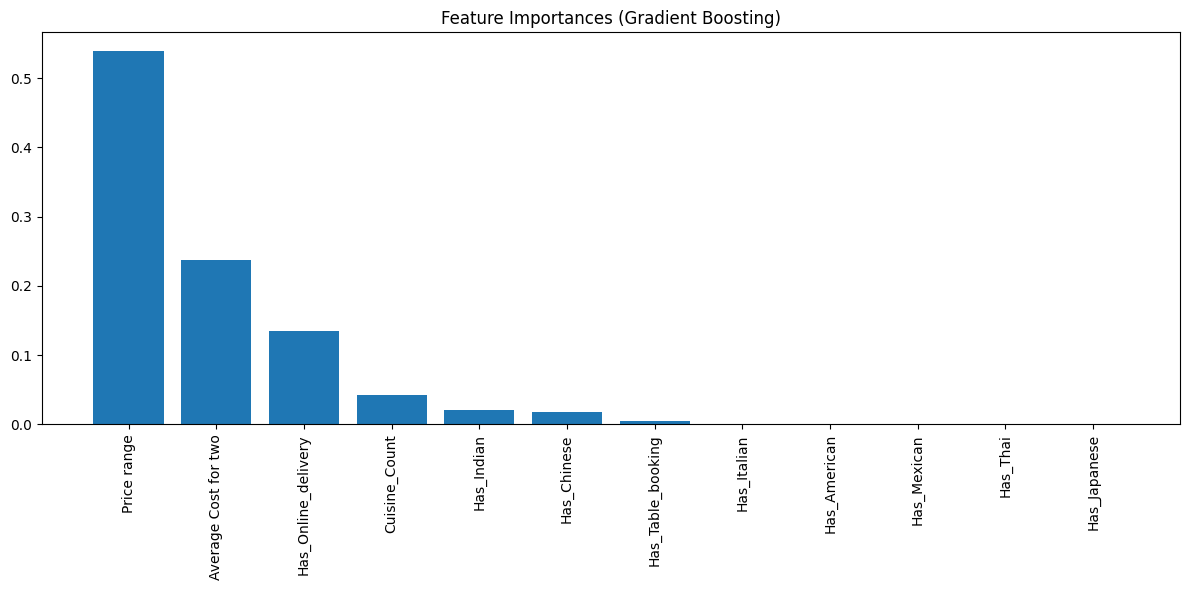

In [ ]:
#task1

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

# Load the dataset
print("Loading dataset...")
df = pd.read_csv("/content/Dataset .csv")  # Note the space in the filename

# Display basic information about the dataset
print("\nDataset Information:")
print(f"Shape of the dataset: {df.shape}")
print("\nFirst 5 rows of the dataset:")
print(df.head())

# Check for missing values
print("\nMissing values in each column:")
print(df.isnull().sum())

# Data preprocessing
print("\nPerforming data preprocessing...")

# Handle missing values
df['Cuisines'].fillna('Unknown', inplace=True)
df.dropna(subset=['Aggregate rating'], inplace=True)  # Drop rows without target variable

# Feature engineering
# Extract the count of cuisines for each restaurant
df['Cuisine_Count'] = df['Cuisines'].apply(lambda x: 0 if x == 'Unknown' else len(str(x).split(',')))

# Create binary indicators for popular cuisines
popular_cuisines = ['American', 'Italian', 'Chinese', 'Japanese', 'Indian', 'Mexican', 'Thai']
for cuisine in popular_cuisines:
    df[f'Has_{cuisine}'] = df['Cuisines'].apply(lambda x: 1 if cuisine in str(x) else 0)

# Check for restaurants with online delivery or table booking
df['Has_Table_booking'] = df['Has Table booking'].apply(lambda x: 1 if x == 'Yes' else 0)
df['Has_Online_delivery'] = df['Has Online delivery'].apply(lambda x: 1 if x == 'Yes' else 0)

# Convert price range to numerical if not already
if df['Price range'].dtype == 'object':
    df['Price range'] = pd.to_numeric(df['Price range'], errors='coerce')

# Prepare features and target
features = ['Price range', 'Average Cost for two', 'Has_Table_booking', 'Has_Online_delivery',
           'Cuisine_Count'] + [f'Has_{cuisine}' for cuisine in popular_cuisines]

X = df[features]
y = df['Aggregate rating']

print("\nSelected features:")
print(X.columns.tolist())

# Exploratory Data Analysis
print("\nPerforming Exploratory Data Analysis...")

# 1. Histogram of ratings
plt.figure(figsize=(10, 6))
plt.hist(df['Aggregate rating'], bins=20, edgecolor='black')
plt.title('Distribution of Restaurant Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.savefig('rating_distribution.png')

# 2. Average Rating vs Price Range
plt.figure(figsize=(10, 6))
avg_rating_by_price = df.groupby('Price range')['Aggregate rating'].mean().reset_index()
plt.bar(avg_rating_by_price['Price range'], avg_rating_by_price['Aggregate rating'])
plt.title('Average Rating by Price Range')
plt.xlabel('Price Range')
plt.ylabel('Average Rating')
plt.savefig('rating_by_price.png')

# 3. Rating vs. Cuisine
plt.figure(figsize=(12, 6))
cuisine_ratings = []
for cuisine in popular_cuisines:
    mean_rating = df[df[f'Has_{cuisine}'] == 1]['Aggregate rating'].mean()
    cuisine_ratings.append({'Cuisine': cuisine, 'Average Rating': mean_rating})
cuisine_df = pd.DataFrame(cuisine_ratings)
cuisine_df = cuisine_df.sort_values('Average Rating', ascending=False)
plt.bar(cuisine_df['Cuisine'], cuisine_df['Average Rating'])
plt.title('Average Rating by Cuisine Type')
plt.xlabel('Cuisine')
plt.ylabel('Average Rating')
plt.xticks(rotation=45)
plt.savefig('rating_by_cuisine.png')

# 4. Correlation matrix
plt.figure(figsize=(12, 10))
correlation_matrix = X.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Features')
plt.savefig('correlation_matrix.png')

# Split the data
print("\nSplitting data into training and testing sets...")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), X.columns)
    ])

# Train multiple models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
}

results = {}

print("\nTraining and evaluating models...")
for name, model in models.items():
    # Create pipeline
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])

    # Train the model
    pipeline.fit(X_train, y_train)

    # Make predictions
    y_pred = pipeline.predict(X_test)

    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results[name] = {
        'RMSE': rmse,
        'MAE': mae,
        'R-squared': r2
    }

    print(f"\n{name} Results:")
    print(f"Root Mean Squared Error: {rmse:.4f}")
    print(f"Mean Absolute Error: {mae:.4f}")
    print(f"R-squared: {r2:.4f}")

    # Plot actual vs predicted
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Actual Rating')
    plt.ylabel('Predicted Rating')
    plt.title(f'{name}: Actual vs Predicted Ratings')
    plt.savefig(f'{name.replace(" ", "_")}_predictions.png')

# Identify the best model
best_model = min(results.items(), key=lambda x: x[1]['RMSE'])
print(f"\nBest Model: {best_model[0]} with RMSE: {best_model[1]['RMSE']:.4f}")

# Feature importance for the best model (if applicable)
if best_model[0] in ['Random Forest', 'Gradient Boosting']:
    model_name = best_model[0]
    model = models[model_name]

    # Get feature importances
    if hasattr(model, 'feature_importances_'):
        importances = models[model_name].feature_importances_
        indices = np.argsort(importances)[::-1]

        plt.figure(figsize=(12, 6))
        plt.title(f'Feature Importances ({model_name})')
        plt.bar(range(X.shape[1]), importances[indices], align='center')
        plt.xticks(range(X.shape[1]), [X.columns[i] for i in indices], rotation=90)
        plt.tight_layout()
        plt.savefig('feature_importances.png')

        print("\nFeature Importances:")
        for i in indices:
            print(f"{X.columns[i]}: {importances[i]:.4f}")

print("\nModel training and evaluation completed!")

In [20]:
#task2
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

class RestaurantRecommender:
    # Remove the nested class definition and update the __init__ method
    def __init__(self, data_path):
        """
        Initialize the restaurant recommender system.

        Parameters:
        -----------
        data_path : str
            Path to the restaurant dataset CSV file.
        """
        print("Initializing Restaurant Recommendation System...")
        self.data_path = data_path
        self.df = None
        self.similarity_matrix = None
        self.feature_matrix = None
        self.preprocessor = None

    # ... (rest of your class methods) ...

    def load_data(self):
        """Load and display basic information about the dataset."""
        print("Loading dataset...")
        # Changed the path from "../Dataset .csv" to "/content/Dataset .csv"
        # Assuming your data is located in the "/content/" directory
        self.df = pd.read_csv("/content/Dataset .csv")

        # Display basic information
        print(f"Dataset shape: {self.df.shape}")
        print("\nFirst few rows:")
        print(self.df.head())

        # Check for missing values
        print("\nMissing values:")
        print(self.df.isnull().sum())

        return self.df

    def preprocess_data(self):
        """Preprocess the data for recommendation."""
        print("\nPreprocessing data...")

        # Handle missing values
        self.df['Cuisines'].fillna('Unknown', inplace=True)

        # Create feature for cuisine count
        self.df['Cuisine_Count'] = self.df['Cuisines'].apply(lambda x: 0 if x == 'Unknown' else len(str(x).split(',')))

        # Convert categorical columns to numerical
        self.df['Has_Table_booking'] = self.df['Has Table booking'].apply(lambda x: 1 if x == 'Yes' else 0)
        self.df['Has_Online_delivery'] = self.df['Has Online delivery'].apply(lambda x: 1 if x == 'Yes' else 0)

        # Extract popular cuisines
        popular_cuisines = ['American', 'Italian', 'Chinese', 'Japanese', 'Indian', 'Mexican', 'Thai',
                           'Seafood', 'Bar Food', 'Pizza', 'BBQ', 'Steak', 'Burger', 'Vegetarian']

        # Create binary features for popular cuisines
        for cuisine in popular_cuisines:
            self.df[f'Has_{cuisine}'] = self.df['Cuisines'].apply(lambda x: 1 if cuisine in str(x) else 0)

        # Define features to be used for recommendations
        self.features = [
            'Price range', 'Average Cost for two', 'Has_Table_booking', 'Has_Online_delivery',
            'Aggregate rating', 'Votes', 'Cuisine_Count'
        ] + [f'Has_{cuisine}' for cuisine in popular_cuisines]

        # Scale numerical features
        self.preprocessor = StandardScaler()
        self.feature_matrix = self.preprocessor.fit_transform(self.df[self.features])

        print(f"Processed features: {self.features}")
        return self.df

    def build_similarity_matrix(self):
        """Build the similarity matrix between restaurants."""
        print("\nBuilding similarity matrix...")
        self.similarity_matrix = cosine_similarity(self.feature_matrix)
        print(f"Similarity matrix shape: {self.similarity_matrix.shape}")
        return self.similarity_matrix

    def recommend_restaurants(self, preferences, top_n=10, verbose=True):
        """
        Recommend restaurants based on user preferences.

        Parameters:
        -----------
        preferences : dict
            Dictionary of user preferences (e.g., {'Price range': 3, 'Has_Italian': 1}).
        top_n : int
            Number of recommendations to return.
        verbose : bool
            Whether to print detailed output.

        Returns:
        --------
        pd.DataFrame
            Top N recommended restaurants.
        """
        if self.similarity_matrix is None:
            self.build_similarity_matrix()

        # Create a user profile vector
        user_profile = np.zeros(len(self.features))

        # Set values based on user preferences
        for i, feature in enumerate(self.features):
            if feature in preferences:
                user_profile[i] = preferences[feature]

        # Scale the user profile using the same scaler
        user_profile_scaled = self.preprocessor.transform([user_profile])[0]

        # Calculate similarity between user profile and all restaurants
        similarities = cosine_similarity([user_profile_scaled], self.feature_matrix)[0]

        # Get top N restaurant indices
        top_indices = similarities.argsort()[-top_n:][::-1]

        # Extract recommended restaurants
        recommendations = self.df.iloc[top_indices].copy()
        recommendations['Similarity_Score'] = similarities[top_indices]

        if verbose:
            print(f"\nTop {top_n} Restaurant Recommendations:")
            for i, (idx, row) in enumerate(recommendations.iterrows(), 1):
                print(f"{i}. {row['Restaurant Name']} (Rating: {row['Aggregate rating']}/5)")
                print(f"   Cuisines: {row['Cuisines']}")
                print(f"   Price Range: {row['Price range']}/4, Cost for Two: {row['Average Cost for two']} {row['Currency']}")
                print(f"   Location: {row['City']}")
                print(f"   Similarity Score: {row['Similarity_Score']:.4f}")
                print()

        return recommendations

    def visualize_preferences(self, recommendations):
        """
        Visualize the characteristics of the recommended restaurants.

        Parameters:
        -----------
        recommendations : pd.DataFrame
            Dataframe containing the recommended restaurants.
        """
        plt.figure(figsize=(15, 10))

        # Plot 1: Rating distribution
        plt.subplot(2, 2, 1)
        sns.histplot(recommendations['Aggregate rating'], bins=10, kde=True)
        plt.title('Rating Distribution of Recommendations')
        plt.xlabel('Rating')
        plt.ylabel('Count')

        # Plot 2: Price range distribution
        plt.subplot(2, 2, 2)
        sns.countplot(x='Price range', data=recommendations)
        plt.title('Price Range Distribution')
        plt.xlabel('Price Range (1-4)')
        plt.ylabel('Count')

        # Plot 3: Cuisine distribution
        plt.subplot(2, 2, 3)
        cuisine_counts = {cuisine: recommendations[f'Has_{cuisine}'].sum()
                         for cuisine in ['American', 'Italian', 'Chinese', 'Japanese', 'Indian', 'Mexican', 'Thai']}
        cuisine_df = pd.DataFrame(list(cuisine_counts.items()), columns=['Cuisine', 'Count'])
        cuisine_df = cuisine_df.sort_values('Count', ascending=False)
        sns.barplot(x='Cuisine', y='Count', data=cuisine_df)
        plt.title('Cuisine Types in Recommendations')
        plt.xticks(rotation=45)

        # Plot 4: Similarity score distribution
        plt.subplot(2, 2, 4)
        sns.histplot(recommendations['Similarity_Score'], bins=10, kde=True)
        plt.title('Similarity Score Distribution')
        plt.xlabel('Similarity Score')
        plt.ylabel('Count')

        plt.tight_layout()
        plt.savefig('recommendation_analysis.png')
        plt.close()

        print("Visualization saved as 'recommendation_analysis.png'")

    def evaluate_recommendation_diversity(self, recommendations):
        """
        Evaluate the diversity of recommendations.

        Parameters:
        -----------
        recommendations : pd.DataFrame
            Dataframe containing the recommended restaurants.

        Returns:
        --------
        dict
            Dictionary containing diversity metrics.
        """
        diversity_metrics = {}

        # Price range diversity
        diversity_metrics['price_range_unique'] = recommendations['Price range'].nunique()
        diversity_metrics['price_range_entropy'] = -sum([(recommendations['Price range'].value_counts()[i]/len(recommendations)) *
                                                       np.log2(recommendations['Price range'].value_counts()[i]/len(recommendations))
                                                       for i in recommendations['Price range'].unique()])

        # Cuisine diversity
        cuisines = ['American', 'Italian', 'Chinese', 'Japanese', 'Indian', 'Mexican', 'Thai']
        cuisine_counts = {cuisine: recommendations[f'Has_{cuisine}'].sum() for cuisine in cuisines}
        total_cuisines = sum(cuisine_counts.values())

        if total_cuisines > 0:
            cuisine_entropy = -sum([(count/total_cuisines) * np.log2(count/total_cuisines)
                                 for cuisine, count in cuisine_counts.items() if count > 0])
        else:
            cuisine_entropy = 0

        diversity_metrics['cuisine_entropy'] = cuisine_entropy

        # City diversity
        diversity_metrics['city_unique'] = recommendations['City'].nunique()

        print("\nRecommendation Diversity Metrics:")
        print(f"Unique Price Ranges: {diversity_metrics['price_range_unique']}")
        print(f"Price Range Entropy: {diversity_metrics['price_range_entropy']:.4f}")
        print(f"Cuisine Entropy: {diversity_metrics['cuisine_entropy']:.4f}")
        print(f"Unique Cities: {diversity_metrics['city_unique']}")

        return diversity_metrics

# Main execution
if __name__ == "__main__":
    # Initialize the recommender
    data_path = "../Dataset .csv"  # Note the space in filename
    recommender = RestaurantRecommender(data_path)

    # Load and preprocess data
    recommender.load_data()
    recommender.preprocess_data()
    recommender.build_similarity_matrix()

    # Example 1: User who prefers high-end Italian restaurants
    print("\n===== Example 1: High-end Italian Restaurant Lover =====")
    preferences1 = {
        'Price range': 4,  # High-end
        'Has_Italian': 1,
        'Has_Table_booking': 1  # Prefers restaurants with table booking
    }
    recommendations1 = recommender.recommend_restaurants(preferences1, top_n=5)
    recommender.visualize_preferences(recommendations1)
    recommender.evaluate_recommendation_diversity(recommendations1)

    # Example 2: User who prefers affordable Asian cuisine
    print("\n===== Example 2: Budget Asian Food Lover =====")
    preferences2 = {
        'Price range': 2,  # Medium-low price
        'Has_Chinese': 1,
        'Has_Japanese': 1,
        'Has_Thai': 1,
        'Has_Online_delivery': 1  # Prefers restaurants with online delivery
    }
    recommendations2 = recommender.recommend_restaurants(preferences2, top_n=5)
    recommender.evaluate_recommendation_diversity(recommendations2)

    # Example 3: User who wants highly-rated restaurants regardless of cuisine
    print("\n===== Example 3: Food Quality Enthusiast =====")
    preferences3 = {
        'Aggregate rating': 4.5,  # High rating
        'Votes': 500  # Popular places with many votes
    }
    recommendations3 = recommender.recommend_restaurants(preferences3, top_n=5)
    recommender.evaluate_recommendation_diversity(recommendations3)

    print("\nRestaurant Recommendation System Complete!")

Initializing Restaurant Recommendation System...
Loading dataset...
Dataset shape: (9551, 21)

First few rows:
   Restaurant ID         Restaurant Name  Country Code              City  \
0        6317637        Le Petit Souffle           162       Makati City   
1        6304287        Izakaya Kikufuji           162       Makati City   
2        6300002  Heat - Edsa Shangri-La           162  Mandaluyong City   
3        6318506                    Ooma           162  Mandaluyong City   
4        6314302             Sambo Kojin           162  Mandaluyong City   

                                             Address  \
0  Third Floor, Century City Mall, Kalayaan Avenu...   
1  Little Tokyo, 2277 Chino Roces Avenue, Legaspi...   
2  Edsa Shangri-La, 1 Garden Way, Ortigas, Mandal...   
3  Third Floor, Mega Fashion Hall, SM Megamall, O...   
4  Third Floor, Mega Atrium, SM Megamall, Ortigas...   

                                     Locality  \
0   Century City Mall, Poblacion, Makati City 


Logistic Regression Results:
Accuracy: 0.5568
Precision: 0.5456
Recall: 0.5568
              precision    recall  f1-score   support

   Excellent       0.00      0.00      0.00        43
        High       0.60      0.54      0.57       570
         Low       0.52      0.50      0.51       468
      Medium       0.55      0.63      0.59       830

    accuracy                           0.56      1911
   macro avg       0.42      0.42      0.42      1911
weighted avg       0.55      0.56      0.55      1911



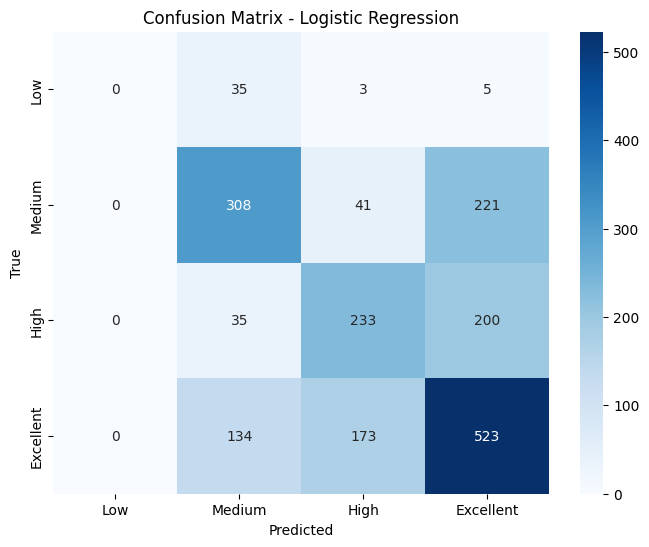


Random Forest Results:
Accuracy: 0.5835
Precision: 0.5849
Recall: 0.5835
              precision    recall  f1-score   support

   Excellent       0.33      0.12      0.17        43
        High       0.67      0.58      0.62       570
         Low       0.51      0.56      0.53       468
      Medium       0.58      0.62      0.60       830

    accuracy                           0.58      1911
   macro avg       0.52      0.47      0.48      1911
weighted avg       0.58      0.58      0.58      1911



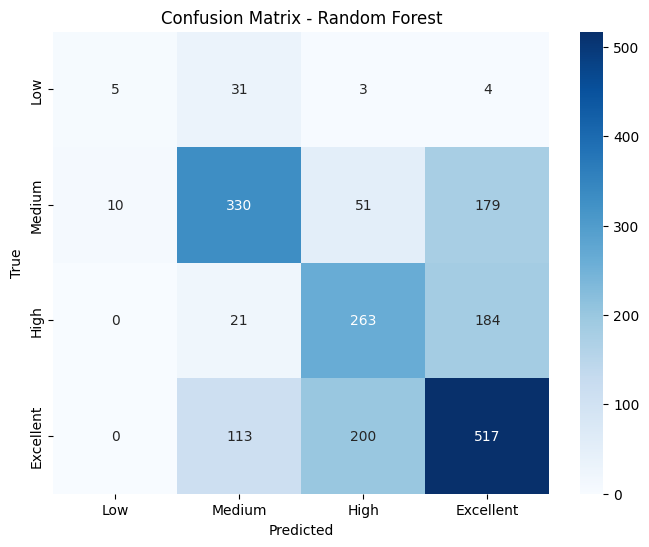


SVM Results:
Accuracy: 0.5667
Precision: 0.5780
Recall: 0.5667
              precision    recall  f1-score   support

   Excellent       1.00      0.02      0.05        43
        High       0.64      0.59      0.61       570
         Low       0.51      0.46      0.48       468
      Medium       0.55      0.64      0.59       830

    accuracy                           0.57      1911
   macro avg       0.68      0.43      0.43      1911
weighted avg       0.58      0.57      0.56      1911



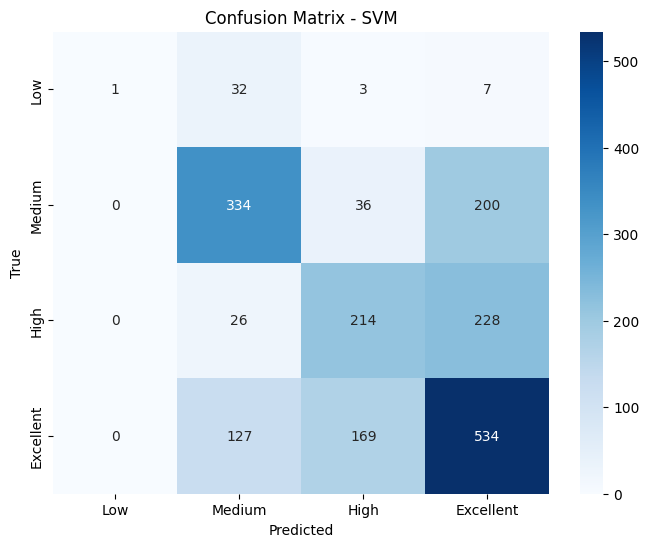


Gradient Boosting Results:
Accuracy: 0.6112
Precision: 0.6103
Recall: 0.6112
              precision    recall  f1-score   support

   Excellent       0.33      0.02      0.04        43
        High       0.68      0.58      0.63       570
         Low       0.59      0.51      0.55       468
      Medium       0.59      0.72      0.65       830

    accuracy                           0.61      1911
   macro avg       0.55      0.46      0.47      1911
weighted avg       0.61      0.61      0.60      1911



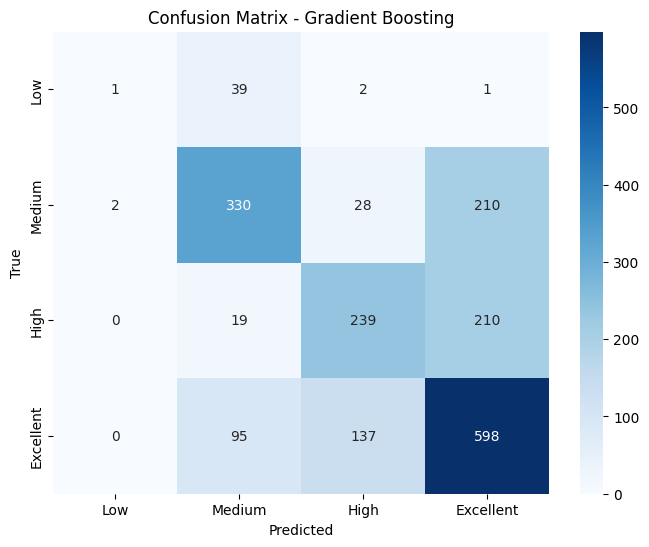


Best performing model: Gradient Boosting with accuracy 0.6112


In [ ]:
# Task 3 cuisine classification
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier

# ... (Your existing code) ...

# Classification Models (add SVM, KMeans, Gradient Boosting)
models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(random_state=42),
    'SVM': SVC(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)
}

# Hyperparameter tuning for SVM
param_grid_svm = {'model__C': [0.1, 1, 10], 'model__gamma': [1, 0.1, 0.01]}
grid_search_svm = GridSearchCV(pipeline, param_grid_svm, cv=5)


results = {}

for name, model in models.items():
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])

    if name == 'SVM':
      pipeline = GridSearchCV(pipeline, param_grid_svm, cv=5)

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0) # Handle zero division
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0) # Handle zero division


    results[name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall
    }

    print(f"\n{name} Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(classification_report(y_test, y_pred, zero_division=0)) # Handle zero division

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

best_classifier = max(results, key=lambda k: results[k]['Accuracy'])
print(f"\nBest performing model: {best_classifier} with accuracy {results[best_classifier]['Accuracy']:.4f}")

#KMeans clustering (example - adapt as needed for your task)
kmeans = KMeans(n_clusters=4, random_state=42) # Choose appropriate number of clusters
kmeans.fit(X)
df['kmeans_cluster'] = kmeans.labels_
#Analyze the clusters if needed


In [21]:
#task 4
import plotly.express as px

# Assuming 'df' is your DataFrame and it contains 'Latitude' and 'Longitude' columns.
# If your latitude and longitude columns have different names, replace 'Latitude' and 'Longitude' accordingly.

fig = px.scatter_mapbox(df, lat="Latitude", lon="Longitude", hover_name="Restaurant Name", hover_data=["City", "Aggregate rating"],
                        color_discrete_sequence=["fuchsia"], zoom=3, height=600)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

# Group restaurants by city and analyze concentration
city_restaurant_counts = df.groupby('City')['Restaurant ID'].count().reset_index()
print(city_restaurant_counts)

# Calculate average rating by city
avg_rating_by_city = df.groupby('City')['Aggregate rating'].mean().reset_index()
print(avg_rating_by_city)

# Analyze cuisine distribution by city (example with top cuisines)
top_cuisines = ['North Indian', 'Chinese', 'South Indian', 'Fast Food', 'Italian'] # Replace with your top cuisines
for cuisine in top_cuisines:
  cuisine_city_counts = df[df['Cuisines'].str.contains(cuisine, na=False)].groupby('City')['Restaurant ID'].count().reset_index()
  print(f"Cuisine: {cuisine}")
cuisine_city_counts


                City  Restaurant ID
0          Abu Dhabi             20
1               Agra             20
2          Ahmedabad             21
3             Albany             20
4          Allahabad             20
..               ...            ...
136          Weirton              1
137  Wellington City             20
138   Winchester Bay              1
139          Yorkton              1
140        ��stanbul             14

[141 rows x 2 columns]
                City  Aggregate rating
0          Abu Dhabi          4.300000
1               Agra          3.965000
2          Ahmedabad          4.161905
3             Albany          3.555000
4          Allahabad          3.395000
..               ...               ...
136          Weirton          3.900000
137  Wellington City          4.250000
138   Winchester Bay          3.200000
139          Yorkton          3.300000
140        ��stanbul          4.292857

[141 rows x 2 columns]
Cuisine: North Indian
Cuisine: Chinese
Cuisine: Sout

,City,Restaurant ID
0,Abu Dhabi,2
1,Agra,3
2,Ahmedabad,10
3,Albany,1
4,Allahabad,3
...,...,...
75,Vineland Station,1
76,Vizag,2
77,Waterloo,2
78,Wellington City,2
